In [1]:
import numpy as np

from collections import defaultdict

from math import pi

from qiskit import transpile

from qiskit.circuit import QuantumCircuit, Parameter

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import StatevectorEstimator, StatevectorSampler

from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_aer import AerSimulator

from scipy.optimize import minimize



$ H(x) = - \sum_i v_i x_i + A(\sum_i w_i x_i - C)^2 $

$A$ is a penalty constant $>$ max($w_i$)

Map binary $x_i = (1 - Z_i) / 2$ into Pauli-Z operators

In [2]:
def INVALID_create_knapsack_hamiltonian(weights, vals, cap, penalty):
    n = len(vals)

    Q = np.zeros((n, n))
    lin = np.zeros(n)

    # obj: -v_i x_i
    lin -= np.array(vals)
    
    for i in range(n):
        lin[i] += penalty * (weights[i] ** 2 - 2 * cap * weights[i])
        for j in range(i + 1, n):
            Q[i, j] += 2 * penalty * weights[i] * weights[j]

    # const = penalty * cap ** 2

    # map to hamiltonian / ising
    paulis = []
    coeffs = []

    for i in range(n):
        # linear term
        if abs(lin[i]) > 1e-9:
            coeffs.append(lin[i] / 2)
            paulis.append("I" * (n - i - 1) + "Z" + "I" * i)

    for i in range(n):
        for j in range(i + 1, n):
            if abs(Q[i, j]) > 1e-9:
                coeffs.append(Q[i, j] / 4)
                label = ["I"] * n
                label[n - i - 1] = "Z"
                label[n - j - 1] = "Z"
                paulis.append("".join(label))
    
    hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
    return hamiltonian
    

$ x_i = \frac{1 - Z_i}{2} $

Linear Term

$ a_i x_i = \frac{a_i}{2} I - \frac{a_i}{2} Z_i $

Quadratic Term

$ b_{ij} x_i x_j = \frac{b_{ij}}{4} I - \frac{b_{ij}}{4} Z_i - \frac{b_{ij}}{4} Z_j + \frac{b_{ij}}{4} Z_i Z_j$  

$ h_i = -\frac{a_i}{2} - \frac{1}{4} \sum_{j \neq i} b_{ij} $

In [3]:
def create_knapsack_hamiltonian(weights, vals, cap, penalty):
    n = len(vals)

    Q = np.zeros((n, n))
    lin = np.zeros(n)

    lin -= np.array(vals, dtype=float)

    for i in range(n):
        lin[i] += penalty * (weights[i] ** 2 - 2 * cap * weights[i])
        for j in range(i + 1, n):
            Q[i, j] += 2 * penalty * weights[i] * weights[j]
    
    h = np.zeros(n)
    J = {}

    h += -lin / 2.0
    for i in range(n):
        for j in range(i + 1, n):
            bij = Q[i, j]
            if abs(bij) > 1e-12:
                h[i] += -bij / 4.0
                h[j] += -bij / 4.0
                J[(i, j)] = J.get((i, j), 0.0) + bij / 4.0
    
    paulis, coeffs = [], []
    for i, c in enumerate(h):
        if abs(c) > 1e-12:
            label = ["I"] * n
            label[n - i - 1] = "Z"
            paulis.append("".join(label))
            coeffs.append(c)
    for (i, j), c in J.items():
        if abs(c) > 1e-12:
            label = ["I"] * n
            label[n - i - 1] = "Z"
            label[n - j - 1] = "Z"
            paulis.append("".join(label))
            coeffs.append(c)

    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

In [4]:
vals = [5, 4, 6]
weights = [2, 3, 4]
cap = 5
pen = 4#sum(vals) #10 # > max(weights)

# problem hamiltonian
hamiltonian = create_knapsack_hamiltonian(weights, vals, cap, pen)

print(hamiltonian)

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[ 6.5+0.j,  8. +0.j, 11. +0.j, 12. +0.j, 16. +0.j, 24. +0.j])


In [5]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

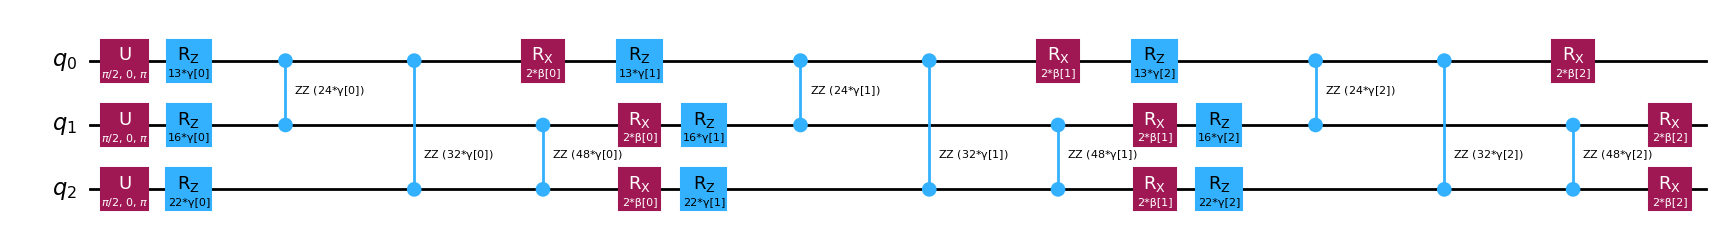

In [85]:
ansatz = QAOAAnsatz(hamiltonian, reps=3)
ansatz.decompose(reps=2).draw("mpl")

In [63]:
estimator = StatevectorEstimator()

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost = cost_func(x0, ansatz, hamiltonian, estimator)
print(cost)

-7.470331718397876


In [64]:
res = minimize(cost_func, x0, 
               args=(ansatz, hamiltonian, estimator),
               method="COBYLA")
print("Optimal params:", res.x)
print("Estimated ground state energy:", res.fun)

Optimal params: [2.98640344 5.06185273 0.28990327 5.440215   2.36444577 1.09525594]
Estimated ground state energy: -22.18807893864443


In [65]:
qc = ansatz.decompose(reps=2) # =3)
qc = qc.copy()
qc.measure_all()
bound = qc.assign_parameters(res.x)

backend = AerSimulator()
tqc = transpile(bound, backend)
job = backend.run(tqc, shots=2048)
counts = job.result().get_counts()

print(counts)
counts_ = dict(sorted(counts.items(), key=lambda x:x[1], reverse=True))
print(counts_)

{'110': 366, '101': 263, '011': 788, '100': 429, '111': 21, '001': 96, '010': 58, '000': 27}
{'011': 788, '100': 429, '110': 366, '101': 263, '001': 96, '010': 58, '000': 27, '111': 21}


In [69]:
total = sum(counts_.values())
dist = {int(bitstr, 2): cnt / total for bitstr, cnt in counts_.items()}

def bits_from_int(k, width):
    b = format(k, f"0{width}b")
#    print("debug b:",b," k:",k," width:",width)
    return list([int(ch) for ch in b])

def score(x_bits):
    val = sum(v for v, b in zip(vals, reversed(x_bits)) if b)
    wt = sum(w for w, b in zip(weights, reversed(x_bits)) if b)
    return val, wt

n = len(vals)

best = (None, -1, None, 0.0)  # (x_bits, value, weight, prob)
for k, p in dist.items():
    x = bits_from_int(k, n)
    val, wt = score(x)
    #print("bits reversed=",x," p=",p, " val=", val, " wt=", wt)
    if wt <= cap and val > best[1]:
        #print("best:",x," p=", float(p))
        best = (x, val, wt, float(p))


x_bits, best_val, best_wt, best_prob = best
picked = [i for i, b in enumerate(reversed(x_bits) or []) if b]

print("\nBest (feasible) sample:")
print("  items picked:", picked)
print("  bitstring   :", ''.join(map(str, x_bits or [])))
print("  value/weight:", best_val, "/", best_wt, f"(capacity {cap})")
print("  sample prob :", best_prob)


Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.384765625


In [70]:
print(dist)

{3: 0.384765625, 4: 0.20947265625, 6: 0.1787109375, 5: 0.12841796875, 1: 0.046875, 2: 0.0283203125, 0: 0.01318359375, 7: 0.01025390625}


In [86]:
methods = ['COBYLA','Nelder-Mead', 'Powell', 'COBYQA', 'SLSQP']

def get_probs(ansatz_, res_):
    qc = ansatz_.decompose(reps=2) # =3)
    qc = qc.copy()
    qc.measure_all()
    bound = qc.assign_parameters(res_.x)
    
    backend = AerSimulator()
    tqc = transpile(bound, backend)
    job = backend.run(tqc, shots=2048)
    counts = job.result().get_counts()
    counts_ = dict(sorted(counts.items(), key=lambda x:x[1], reverse=True))

    total = sum(counts_.values())
    dist = {int(bitstr, 2): cnt / total for bitstr, cnt in counts_.items()}
    return dist

def get_best_pick(dist_):
    n = len(vals)
    best = (None, -1, None, 0.0)  # (x_bits, value, weight, prob)
    for k, p in dist_.items():
        x = bits_from_int(k, n)
        val, wt = score(x)
        if wt <= cap and val > best[1]:
            best = (x, val, wt, float(p))
    
    x_bits, best_val, best_wt, best_prob = best
    picked = [i for i, b in enumerate(reversed(x_bits) or []) if b]
    
    print("\nBest (feasible) sample:")
    print("  items picked:", picked)
    print("  bitstring   :", ''.join(map(str, x_bits or [])))
    print("  value/weight:", best_val, "/", best_wt, f"(capacity {cap})")
    print("  sample prob :", best_prob)
    return (''.join(map(str, x_bits or [])), best_prob)


def iterate(method_, ham_, ansatz_, x0_):
    exp_res = minimize(cost_func, x0_, 
               args=(ansatz_, ham_, estimator),
               method=method_)
    all_probs = get_probs(ansatz_, exp_res)
    best_binstr, best_prob = get_best_pick(all_probs)
    return best_binstr, best_prob


In [88]:
from collections import defaultdict

tabulate = defaultdict(list)
penalty = np.linspace(max(weights), 10*max(weights), num=5)

for pen_ in penalty:
    hamp = create_knapsack_hamiltonian(weights, vals, cap, pen_)
    print("Hamiltonian for penalty:", pen_, " is ", hamp)
    ansatz_p = QAOAAnsatz(hamp, reps=3)
    x0_ = 2 * np.pi * np.random.rand(ansatz_p.num_parameters)
    for m in methods:
        for i in range(10):
            print(f"ITER {i+1}, METHOD={m}")
            best_binstr, best_p = iterate(m, hamp, ansatz_p, x0_)
            tabulate[m].append((best_binstr, best_p, pen_))
        print("Exit:",m, " for penalty:", pen)
    


Hamiltonian for penalty: 4.0  is  SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[ 6.5+0.j,  8. +0.j, 11. +0.j, 12. +0.j, 16. +0.j, 24. +0.j])
ITER 1, METHOD=COBYLA

Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.08837890625
ITER 2, METHOD=COBYLA

Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.08984375
ITER 3, METHOD=COBYLA

Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.09375
ITER 4, METHOD=COBYLA

Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.10546875
ITER 5, METHOD=COBYLA

Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 011
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.091796875
ITER 6, METHOD=COBYLA

Best (feasible) sample:
  items picked: [

In [90]:
df_dict = {'methods':[], 'best binstr': [], 'best probability': [], 'penalty':[]}

for item in tabulate:
    for binstr, prob, penalty in tabulate[item]:
        df_dict['best binstr'].append(binstr)
        df_dict['best probability'].append(prob)
        df_dict['methods'].append(item)
        df_dict['penalty'].append(penalty)


In [91]:
import pandas as pd
df = pd.DataFrame(df_dict)
df

,methods,best binstr,best probability,penalty
0,COBYLA,011,0.088379,4.0
1,COBYLA,011,0.089844,4.0
2,COBYLA,011,0.093750,4.0
3,COBYLA,011,0.105469,4.0
4,COBYLA,011,0.091797,4.0
...,...,...,...,...
245,SLSQP,011,0.802734,40.0
246,SLSQP,011,0.788574,40.0
247,SLSQP,011,0.801270,40.0
248,SLSQP,011,0.791992,40.0


In [102]:
best_probs_each_method = dict()

for m in methods:
    best_prob_df = df[df['methods']==m]
    best_prob = best_prob_df['best probability'].max()
    best_penalty = best_prob_df[best_prob_df['best probability']==best_prob]['penalty'].iloc[0]
    best_probs_each_method[m]=(best_prob,best_penalty)

print(best_probs_each_method)


{'COBYLA': (0.93505859375, 31.0), 'Nelder-Mead': (0.60888671875, 40.0), 'Powell': (0.71240234375, 40.0), 'COBYQA': (0.6865234375, 22.0), 'SLSQP': (0.80908203125, 40.0)}


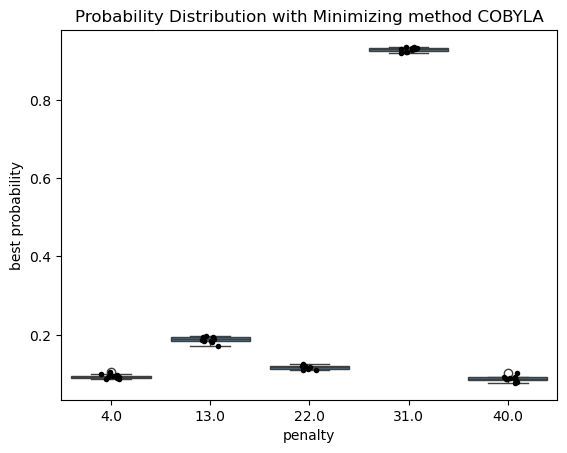

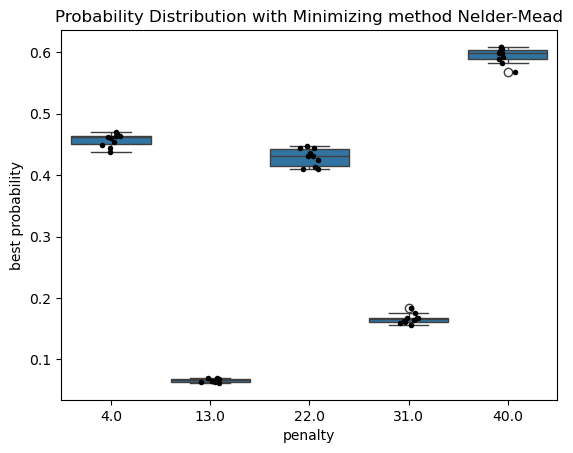

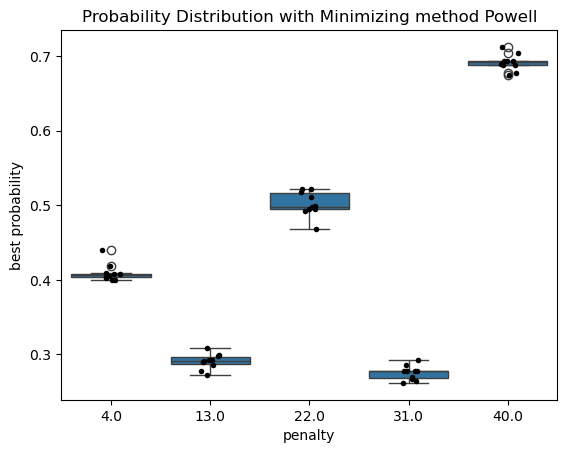

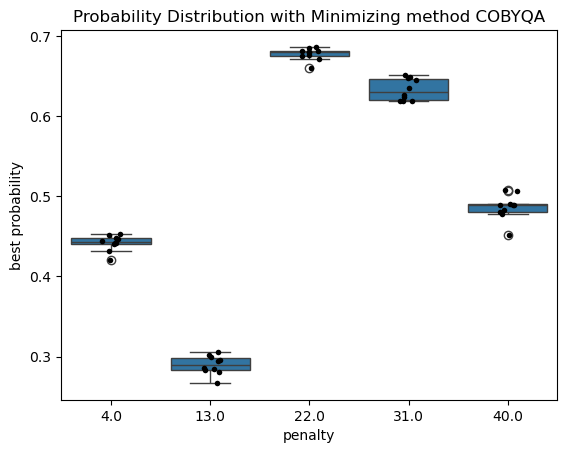

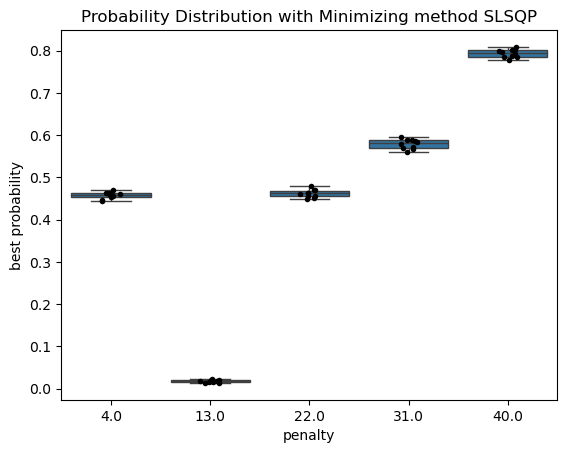

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df_, name):
    sns.boxplot(x="penalty", y="best probability", data=df_)
    sns.stripplot(x="penalty", y="best probability", data=df_, color="black", size=4, jitter=True)
    plt.title(name)
    plt.show()

for m in methods:
    method_df = df[df['methods']==m]
    title = f'Probability Distribution with Minimizing method {m}'
    plot(method_df, title)

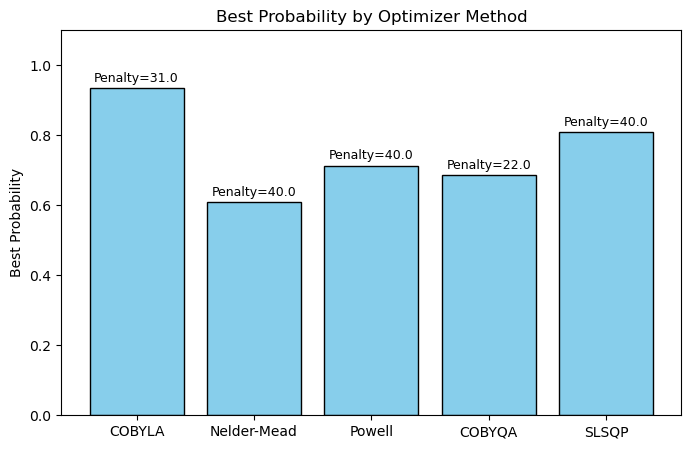

In [109]:
best_probabilities = [v[0] for v in best_probs_each_method.values()]
penalties = [v[1] for v in best_probs_each_method.values()]

# Create bar plot for probabilities
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, best_probabilities, color="skyblue", edgecolor="black")

# Annotate bars with penalty values
for bar, penalty in zip(bars, penalties):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f"Penalty={penalty}", ha='center', va='bottom', fontsize=9)

plt.title("Best Probability by Optimizer Method")
plt.ylabel("Best Probability")
plt.ylim(0, 1.1)
plt.show()